In [36]:
import requests
import re
import json
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import _thread
import time
import jieba
import jieba.analyse
from collections import Counter
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt

# PTT 八卦版網址
#PTT_URL = 'https://www.ptt.cc/bbs/Gossiping/index.html'
PTT_URL = 'https://www.ptt.cc/bbs/HatePolitics/index.html'

ModuleNotFoundError: No module named 'dict'

In [2]:
def crawl_article(url):
    response = requests.get(url, cookies={'over18': '1'})
    response.encoding = 'utf-8'

    # 假設網頁回應不是 200 OK 的話, 我們視為傳送請求失敗
    if response.status_code != 200:
        print('Error - {} is not available to access'.format(url))
        return

    # 將網頁回應的 HTML 傳入 BeautifulSoup 解析器, 方便我們根據標籤 (tag) 資訊去過濾尋找
    soup = BeautifulSoup(response.text, 'html5lib')

    # 取得文章內容主體
    main_content = soup.find(id='main-content')

    # 假如文章有屬性資料 (meta), 我們在從屬性的區塊中爬出作者 (author), 文章標題 (title), 發文日期 (date)
    metas = main_content.select('div.article-metaline')
    author = ''
    title = ''
    date = ''
    author_id = ''
    author_name = ''
    if metas:
        if metas[0].select('span.article-meta-value')[0]:
            author = metas[0].select('span.article-meta-value')[0].string
            author_separate = author.split(' ')
            author_id = author_separate[0].strip()
            
            if len(author_separate) > 1:
                author_name = author_separate[1].strip()[1:-1]
                
        if metas[1].select('span.article-meta-value')[0]:
            title = metas[1].select('span.article-meta-value')[0].string
        if metas[2].select('span.article-meta-value')[0]:
            date = metas[2].select('span.article-meta-value')[0].string

        # 從 main_content 中移除 meta 資訊（author, title, date 與其他看板資訊）
        #
        # .extract() 方法可以參考官方文件
        #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#extract
        for m in metas:
            m.extract()
        for m in main_content.select('div.article-metaline-right'):
            m.extract()

    # 取得留言區主體
    pushes = main_content.find_all('div', class_='push')
    for p in pushes:
        p.extract()

    # 假如文章中有包含「※ 發信站: 批踢踢實業坊(ptt.cc), 來自: xxx.xxx.xxx.xxx」的樣式
    # 透過 regular expression 取得 IP
    # 因為字串中包含特殊符號跟中文, 這邊建議使用 unicode 的型式 u'...'
    try:
        ip = main_content.find(text=re.compile(u'※ 發信站:'))
        ip = re.search('[0-9]*\.[0-9]*\.[0-9]*\.[0-9]*', ip).group()
    except Exception as e:
        ip = ''

    # 移除文章主體中 '※ 發信站:', '◆ From:', 空行及多餘空白 (※ = u'\u203b', ◆ = u'\u25c6')
    # 保留英數字, 中文及中文標點, 網址, 部分特殊符號
    #
    # 透過 .stripped_strings 的方式可以快速移除多餘空白並取出文字, 可參考官方文件
    #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#strings-and-stripped-strings
    filtered = []
    for v in main_content.stripped_strings:
        # 假如字串開頭不是特殊符號或是以 '--' 開頭的, 我們都保留其文字
        if v[0] not in [u'※', u'◆'] and v[:2] not in [u'--']:
            filtered.append(v)

    # 定義一些特殊符號與全形符號的過濾器
    expr = re.compile(u'[^一-龥。；，：“”（）、？《》\s\w:/-_.?~%()]')
    for i in range(len(filtered)):
        filtered[i] = re.sub(expr, '', filtered[i])

    # 移除空白字串, 組合過濾後的文字即為文章本文 (content)
    filtered = [i for i in filtered if i]
    content = ' '.join(filtered)

    # 處理留言區
    # p 計算推文數量
    # b 計算噓文數量
    # n 計算箭頭數量
    p, b, n = 0, 0, 0
    messages = []
    for push in pushes:
        # 假如留言段落沒有 push-tag 就跳過
        if not push.find('span', 'push-tag'):
            continue

        # 過濾額外空白與換行符號
        # push_tag 判斷是推文, 箭頭還是噓文
        # push_userid 判斷留言的人是誰
        # push_content 判斷留言內容
        # push_ipdatetime 判斷留言日期時間
        push_tag = push.find('span', 'push-tag').string.strip(' \t\n\r')
        push_userid = push.find('span', 'push-userid').string.strip(' \t\n\r')
        push_content = push.find('span', 'push-content').strings
        push_content = ' '.join(push_content)[1:].strip(' \t\n\r')
        push_ipdatetime = push.find('span', 'push-ipdatetime').string.strip(' \t\n\r')

        # 整理打包留言的資訊, 並統計推噓文數量
        messages.append({
            'push_tag': push_tag,
            'push_userid': push_userid,
            'push_content': push_content,
            'push_ipdatetime': push_ipdatetime})
        if push_tag == u'推':
            p += 1
        elif push_tag == u'噓':
            b += 1
        else:
            n += 1

    # 統計推噓文
    # count 為推噓文相抵看這篇文章推文還是噓文比較多
    # all 為總共留言數量
    message_count = {'all': p + b + n, 'count': p - b, 'push': p, 'boo': b, 'neutral': n}

    # 整理文章資訊

    data = {
        'url': url,
        #'article_author': author,
        'article_author_id': author_id,
        'article_author_name': author_name,
        'article_title': title,
        'article_date': date,
        'article_content': content,
        'ip': ip,
        'message_count': message_count,
        'messages': messages
    }

    return data

In [3]:
def crawl_comment(amount=50):

    all_data = []
    counter = 0
    nextPage = PTT_URL

    while counter <= amount:
        # 對文章列表送出請求並取得列表主體
        resp = requests.get(nextPage, cookies={'over18': '1'})
        resp.encoding = 'utf-8'

        soup = BeautifulSoup(resp.text, 'html5lib')
        main_list = soup.find('div', class_='bbs-screen')

        nextPage = soup.find('div', 'btn-group btn-group-paging').find_all('a')[1]['href']
        nextPage = 'https://www.ptt.cc' + nextPage

        # 依序檢查文章列表中的 tag, 遇到分隔線就結束, 忽略這之後的文章
        for div in main_list.findChildren('div', recursive=False):

            class_name = div.attrs['class']

            # 遇到分隔線要處理的情況
            if class_name and 'r-list-sep' in class_name:
                print('Reach the last article of this page')
                break
            # 遇到目標文章
            if class_name and 'r-ent' in class_name:
                div_title = div.find('div', class_='title')
                a_title = div_title.find('a', href=True)

                #如果文章已經被刪除，就跳過
                if not a_title:
                    continue

                article_URL = urljoin(PTT_URL, a_title['href'])
                article_title = a_title.text
                print('Parse {} - {}'.format(article_title, article_URL))

                if len(all_data) > amount:
                    print(f'Stop crawling due to reaching the amount. Amount: {len(all_data)}')
                    return all_data
                
                # 呼叫上面寫好的 function 來對文章進行爬蟲
                parse_data = crawl_article(article_URL)
                #parse_data = _thread.start_new_thread(crawl_article, (article_URL, ))
                
                '''
                if counter > amount:
                    time.sleep(2)
                    print(f'Stop crawling due to reaching the amount. Amount: {len(all_data)}')
                    return all_data
                '''

                counter += 1

                # 將爬完的資料儲存
                all_data.append(parse_data)

    return all_data

In [4]:
def save_data(data):
    # 將爬完的資訊存成 json 檔案
    with open('parse_data.json', 'w+', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

def load_data(path):
    # 讀取之前存成 json 檔案的資訊
    with open(path, 'r', encoding='utf-8') as reader:
        data = json.load(reader)

    return data

In [5]:
def getStopWord():
    stopWords = list()
    with open('cn_stopwords.txt', 'r', encoding='utf-8') as reader:
        rows = reader.readlines()
        for row in rows:
            if len(row.strip()) > 0:
                stopWords.append(row.strip())
    return stopWords

In [6]:
def jiebaWord(content, topk=20):
    regStr = '\s+|[0-9a-zA-Z_\{\}\(\)（）\./:~\=]+'
    regex = re.compile(regStr)
    
    jieba.set_dictionary('dict.txt.big') # 使用繁體辭庫
    jieba.load_userdict('user_dict.txt')  #自定義詞彙  
    jieba.analyse.set_stop_words('cn_stopwords.txt')
    
    stopWords = getStopWord()
    
    words = jieba.cut(content, cut_all=False)
    
    filterWords_list2 = [ w for w in words if w not in stopWords and not regex.match(w)]
    filterWords_str = ''.join(filterWords_list2)
    
    tags = jieba.analyse.extract_tags(filterWords_str, topk)
        
    count = []
    for t in tags:
        count.append(filterWords_list2.count(t))
    tagspd = pd.DataFrame([tags, count]).T
    tagspd = tagspd.rename({0:'KeyWords', 1:'Times'}, axis='columns')
    return tagspd, tags
    

In [7]:
def wordcloudPTT(tags):
    text = " ".join(tags)
    font_path = 'msjh.ttc'
    wordcloud = WordCloud(width=1200, height=600, max_font_size=200, max_words=200, 
                          background_color='black', font_path=font_path, colormap='Dark2').generate(text)
    plt.figure(dpi=600)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [42]:
def splitMessage(data):
    message_info = list()

    for row in data:

        messages = row['messages']
        if messages:
            for message in messages:
                message_info.extend(messages)
    
    
    return message_info

In [9]:
def jiebaCount(data, columnName, topK = 20):
    all_content = ''

    for d in data:
        all_content += d[columnName]

    content_pd, content_tags = jiebaWord(all_content, topK)
    
    return content_pd, content_tags

In [10]:
data = crawl_comment(50)
save_data(data)

Parse [討論] 讓政治回歸理性 - https://www.ptt.cc/bbs/HatePolitics/M.1592381317.A.B31.html
Parse Re: [討論] 陳時中今天突然開車了，你各位有準備嗎 - https://www.ptt.cc/bbs/HatePolitics/M.1592381370.A.A2F.html
Parse [黑特] 我看國民黨乾脆派吳敦義去高雄當砲灰算了 - https://www.ptt.cc/bbs/HatePolitics/M.1592381435.A.7D5.html
Parse Re: [討論] 陳時中今天突然開車了，你各位有準備嗎 - https://www.ptt.cc/bbs/HatePolitics/M.1592381765.A.A71.html
Parse Re: [討論] 民眾黨死心吧 國民黨秘書長李乾龍說話了 - https://www.ptt.cc/bbs/HatePolitics/M.1592381789.A.398.html
Parse [討論] 國民黨跟民進黨怎麼看民眾黨? - https://www.ptt.cc/bbs/HatePolitics/M.1592381869.A.7FE.html
Parse Re: [新聞] 蔡壁如喊話國民黨「自信一點」：陳其邁 - https://www.ptt.cc/bbs/HatePolitics/M.1592381932.A.B7F.html
Parse [新聞] 北漂返鄉 高雄勞工局坦承只有14人 - https://www.ptt.cc/bbs/HatePolitics/M.1592382015.A.8FB.html
Parse [新聞] 遏止首爾都會區房價飇漲 韓國緊縮房貸規 - https://www.ptt.cc/bbs/HatePolitics/M.1592382264.A.7AD.html
Parse [Live] 雲端最前線鍾小平說阿中想選台北市長 - https://www.ptt.cc/bbs/HatePolitics/M.1592382290.A.FD6.html
Parse [新聞] 高市長補選 民眾黨認為變數多仍需審慎評 - https://www.ptt.cc/bbs/HatePolitics/M.15923

In [11]:
content_pd, content_tags = jiebaCount(data, 'article_content', 40)

Building prefix dict from C:\Users\10904085\Desktop\cupoy\web\Final\dict.txt.big ...
Loading model from cache C:\Users\10904085\AppData\Local\Temp\jieba.ud7b4c081ac1abb7be4a3bfdb2dc19a8e.cache
Loading model cost 3.156 seconds.
Prefix dict has been built successfully.


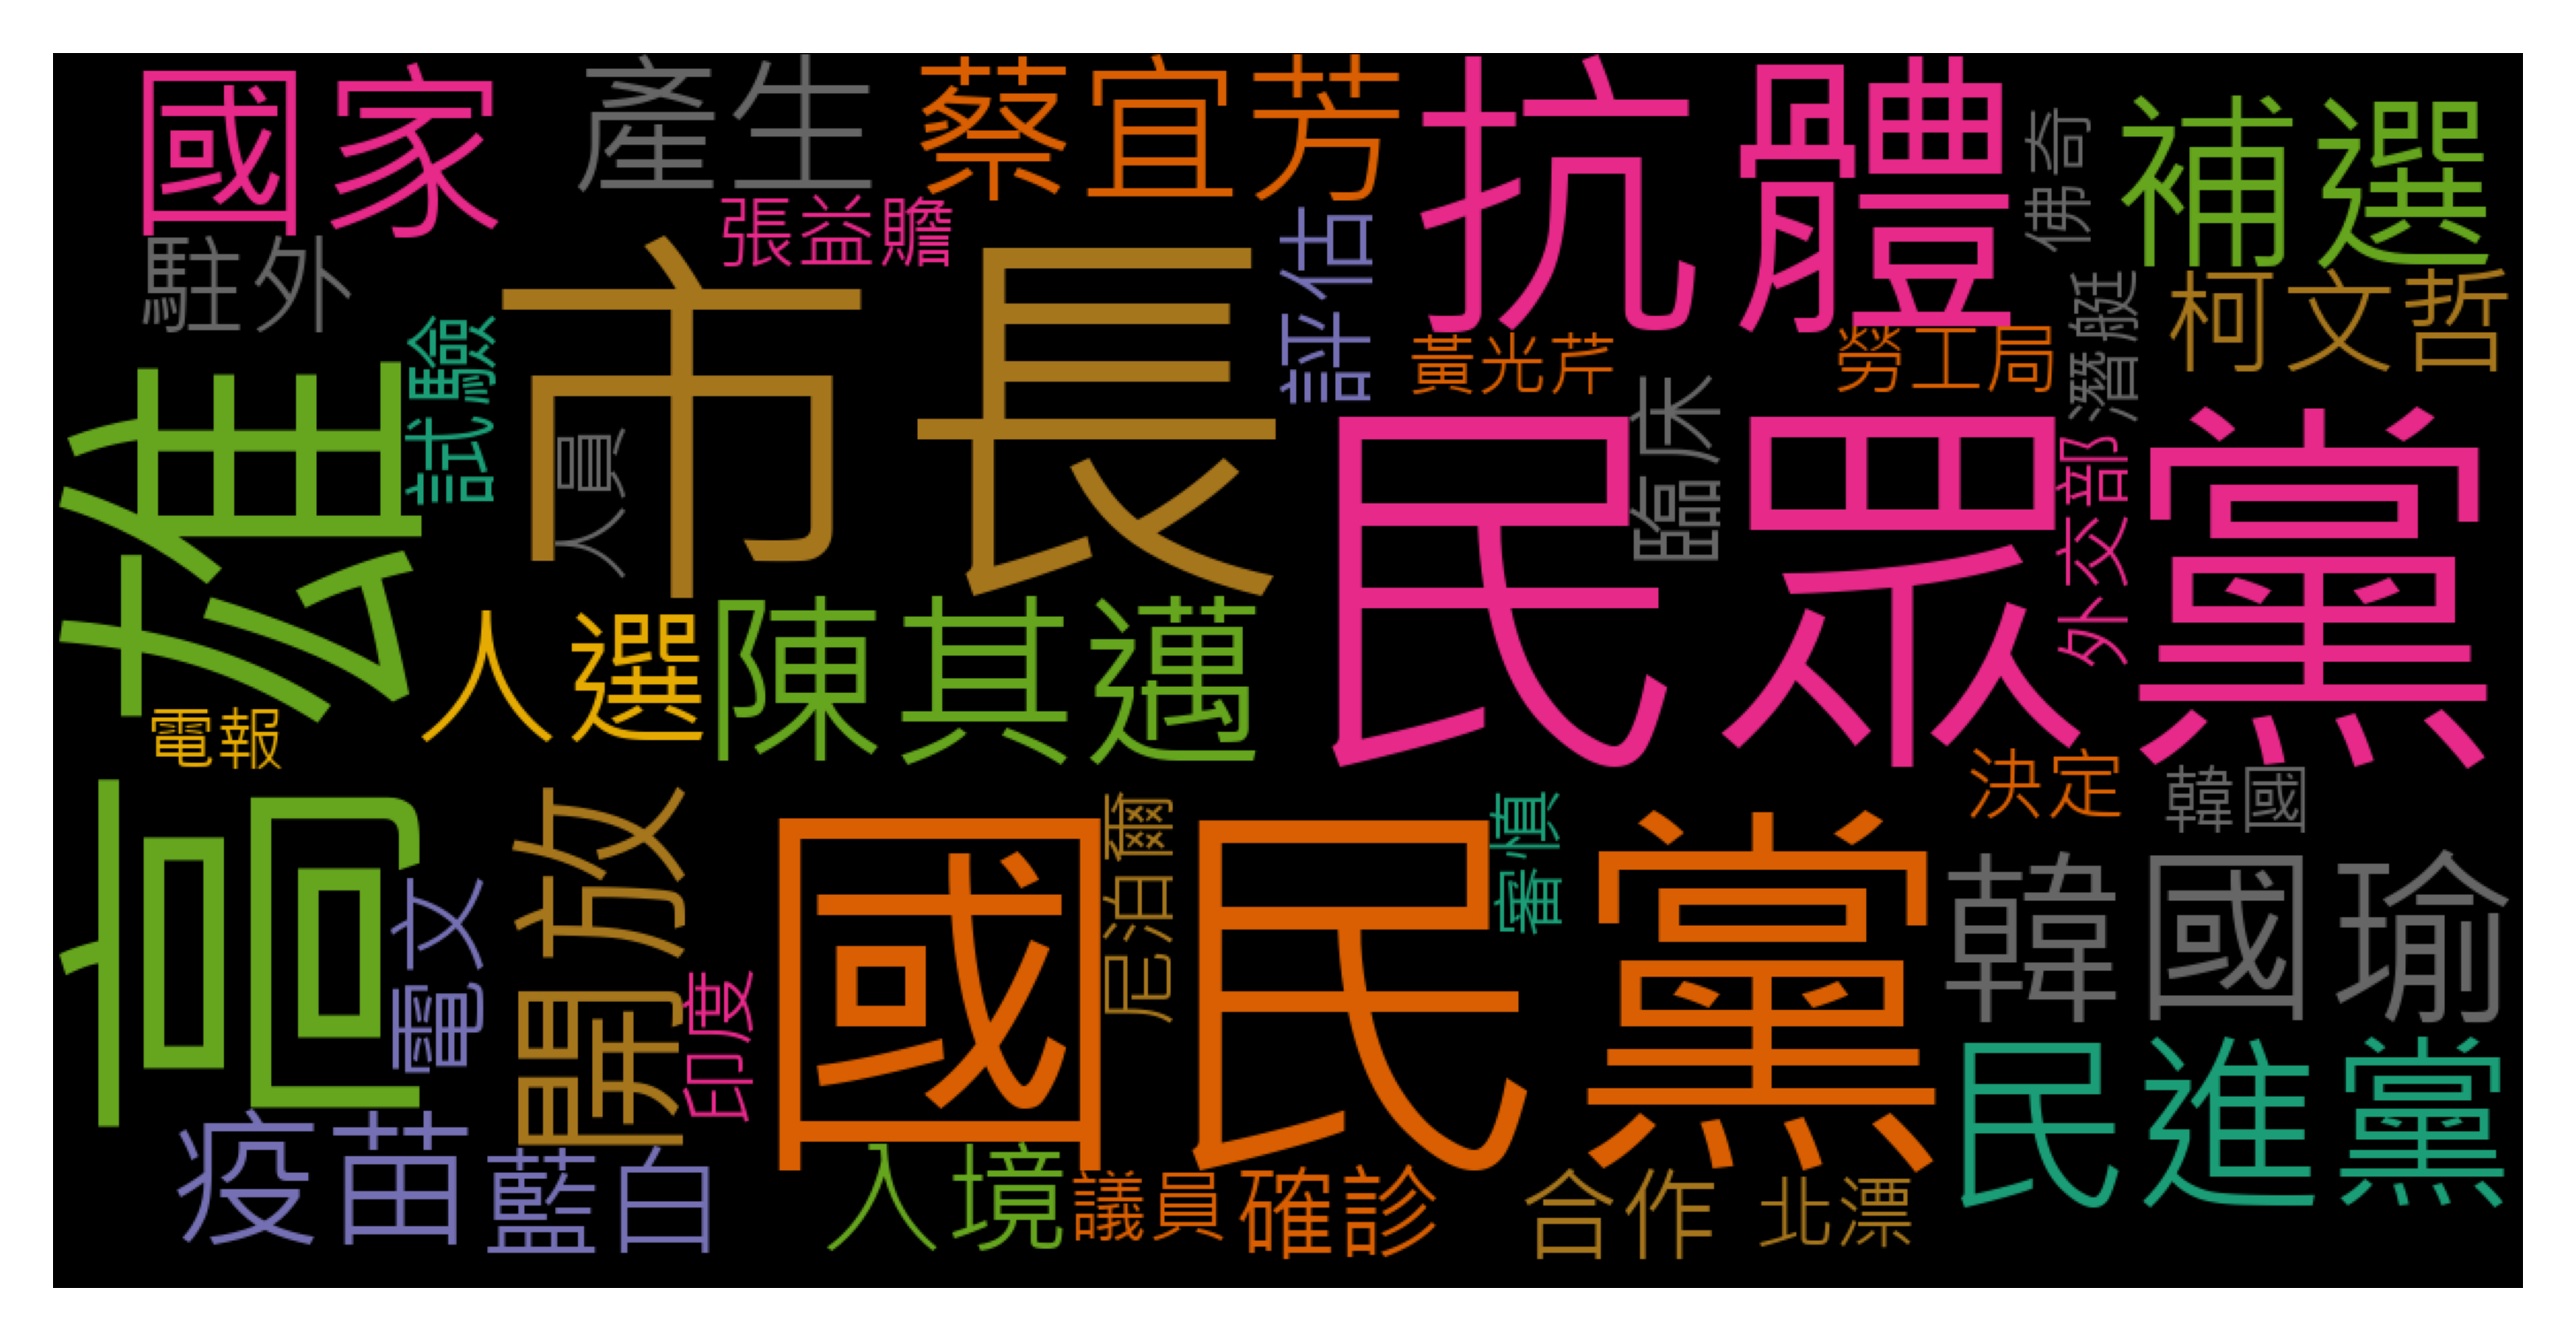

In [12]:
wordcloudPTT(content_tags)

In [13]:
content_pd.sort_values(by=['Times'], ascending = False)

,KeyWords,Times
0,市長,45
1,民眾黨,42
3,高雄,35
2,國民黨,34
22,合作,28
4,抗體,26
13,疫苗,25
5,韓國瑜,23
33,印度,22
6,補選,19


In [43]:
messageInfo = splitMessage(data)
message_pd, message_tags = jiebaCount(messageInfo, 'push_content', 40)

TypeError: unhashable type: 'dict'

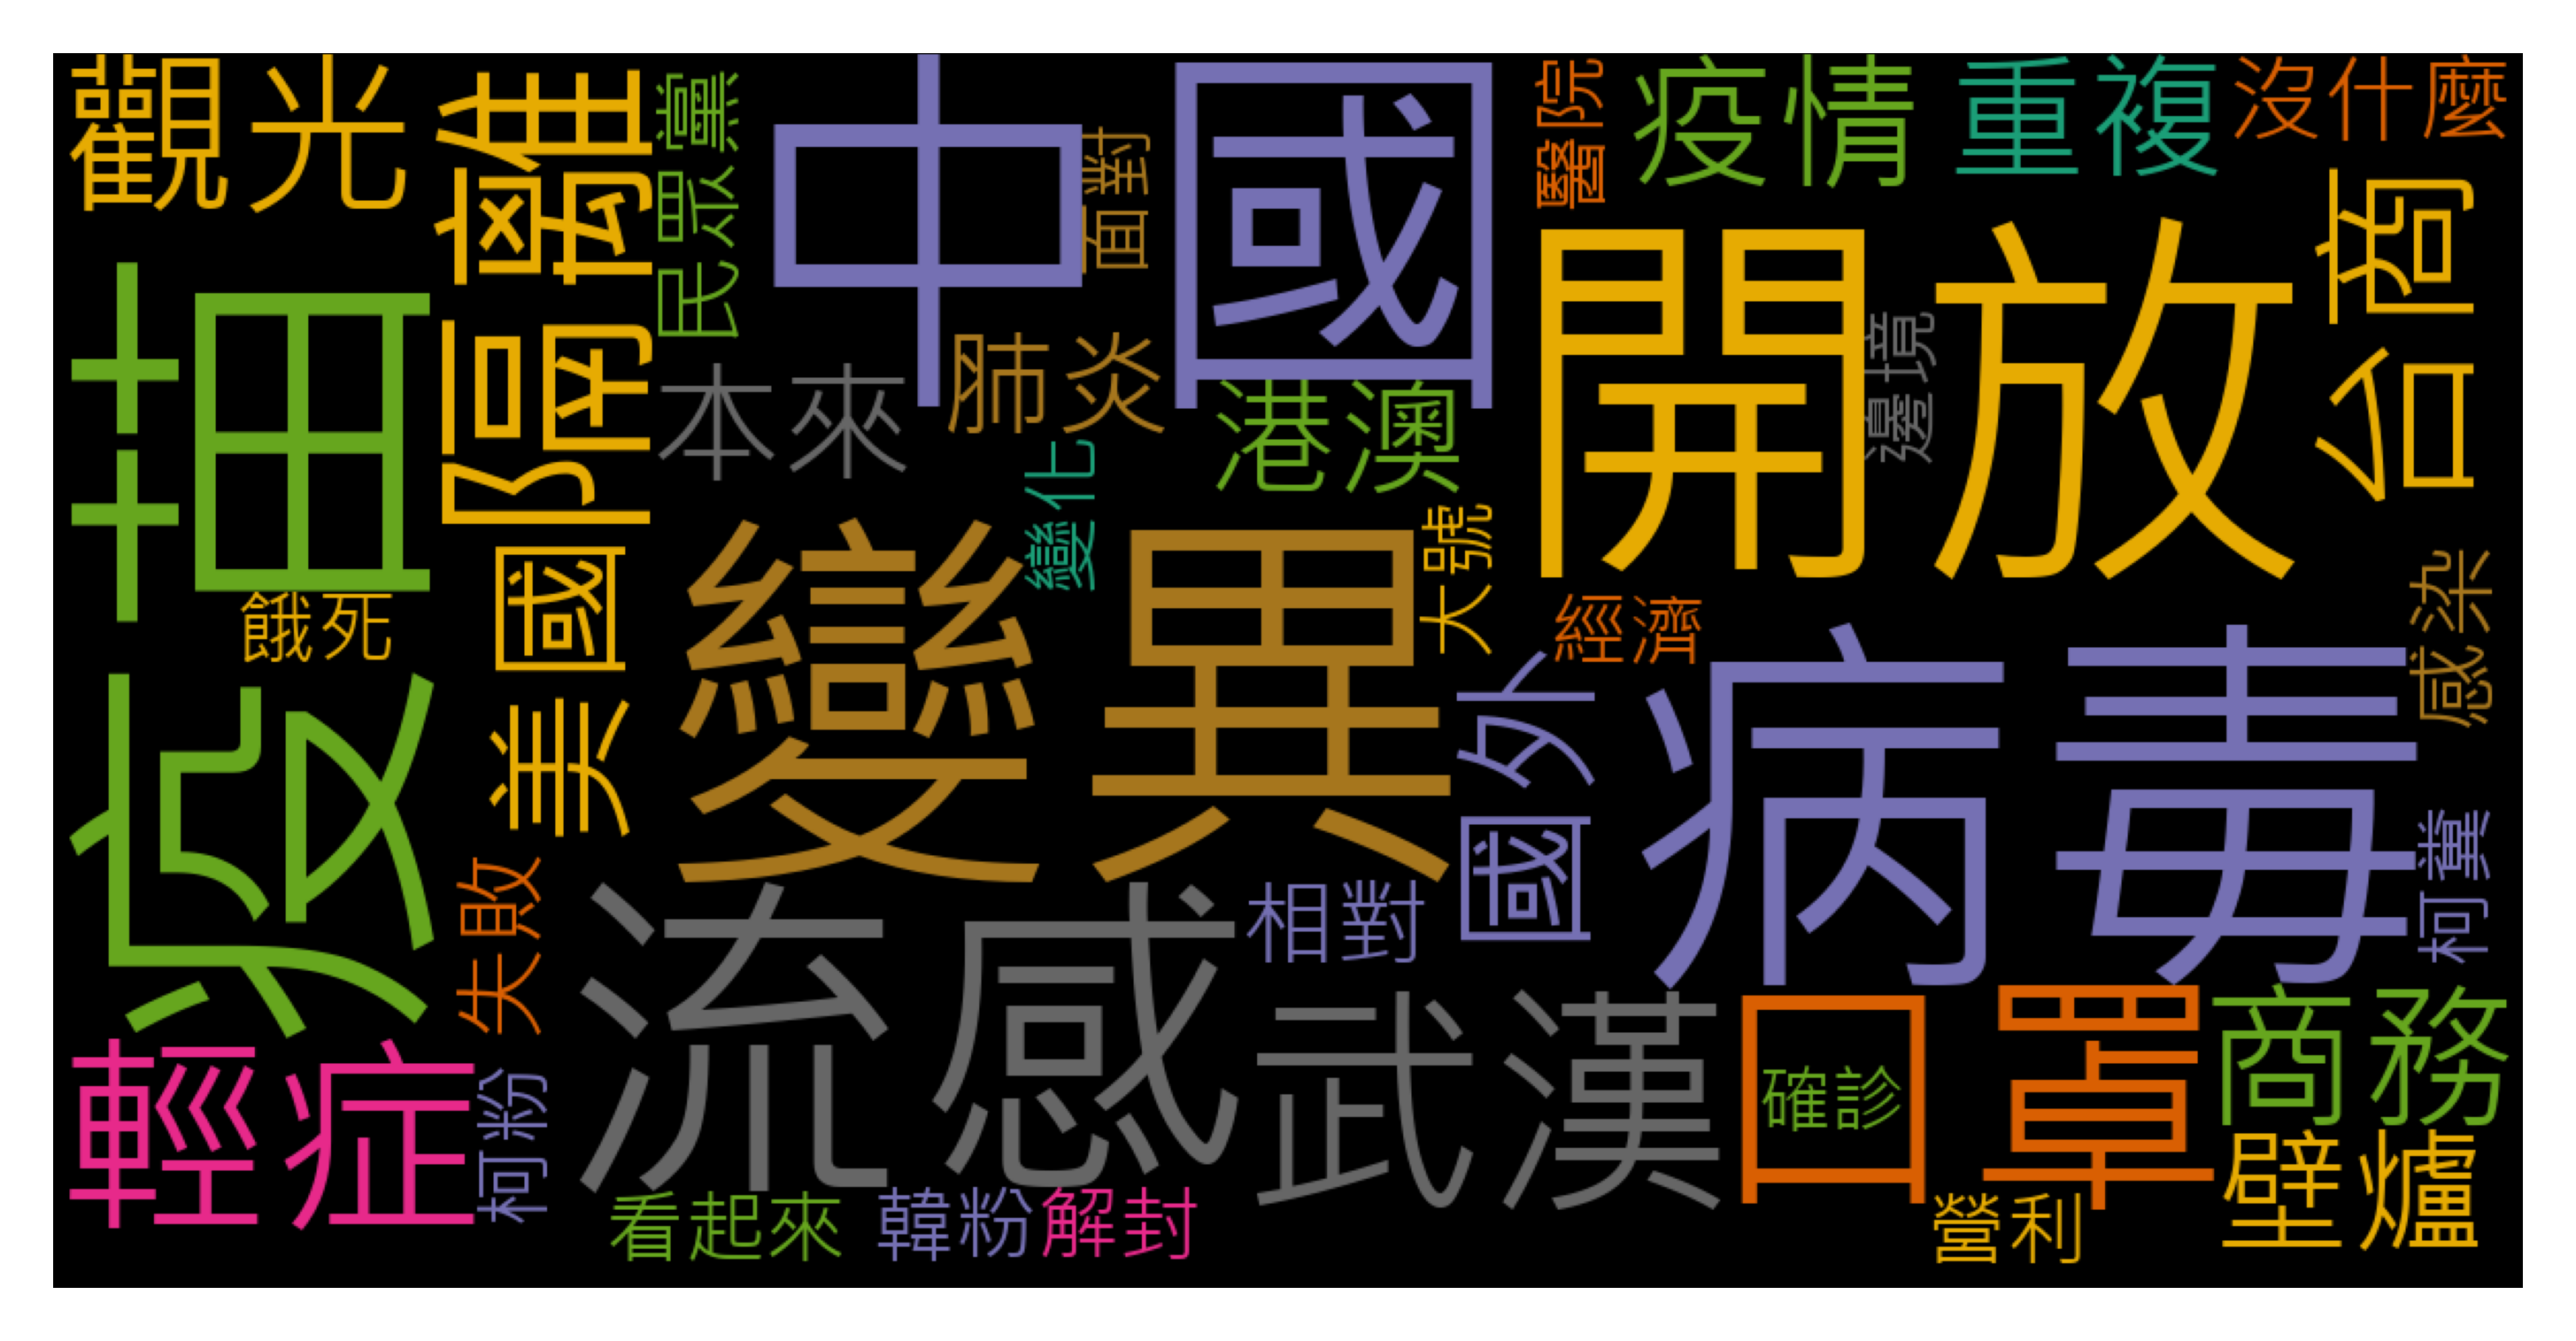

In [15]:
wordcloudPTT(message_tags)

In [16]:
testpd = pd.DataFrame(messageInfo)
testpd.head(100)

,push_tag,push_userid,push_content,push_ipdatetime
0,推,whitenoise,網軍該死，背後付錢的客戶更該死,06/17 16:09
1,推,cblade,你先看看版名,06/17 16:10
2,推,cloudccw,你先看看分類,06/17 16:11
3,推,CTC0115,你可以開一個新看版 LovePolitics 應該會很冷清吧,06/17 16:14
4,→,bb255052,我覺得就有點像是毒品，你可以責怪買家，,06/17 16:15
...,...,...,...,...
95,→,alinalovers,#1UlAv7hO (HatePolitics),06/17 16:23
96,→,nnkj,請理性論述共產黨是否為分裂兩岸的元凶,06/17 16:23
97,→,alinalovers,還是這種？,06/17 16:24
98,→,alinalovers,#1UYraQ1O (HatePolitics),06/17 16:24


In [17]:
def articleCollect(inputpd, author, content, times):
        ## 整理每個推/發文id的全部發文
        ##     每個推/發文ip的全部id
        temp = []
        for name in inputpd[author]: # 抓每個發/推文者的id/ip
            if not name in temp:
                temp.append(name)
        tempD = pd.DataFrame(temp)   # 將每個發/推文者的id/ip預先變成dataframe以便後續填補資料
        tempD = tempD.rename({0:author}, axis='columns')
        temp = []       # 裝每個發/推文者的id/ip
        tempL = []      # 裝每個id/ip的推/發文數或推/發文人數
        allArticle = '' # 全部發文內容彙整 -> 了解最近大家關心的
        pdCount = 0
        for name in tempD[author]:
            temppd = inputpd[inputpd[author]==name]
            for detail in temppd[content]:
                if ('author' in author)*('article' in content):
                    allArticle += detail+' ' # 全部發文內容彙整 -> 了解最近大家關心的
                try:
                    if ('ip' in author):
                        if not detail in temp[pdCount]:
                            temp[pdCount] = temp[pdCount]+';'+detail        
                    else:
                        temp[pdCount] = temp[pdCount]+';'+detail        
                except:
                    temp.append(detail)     
            if ('ip' in author):
                tempL.append(len(temp[pdCount].split(';'))) # 拿到ip -> 整理此ip有幾人用
            else:
                tempL.append(len(temppd[content]))          # 沒拿到ip -> 整理此id發/推過幾篇文
            pdCount +=1
        tempD[content] = temp
        tempD[times] = tempL
        tempD = tempD.sort_values(by=times, ascending=False).reset_index()
        '''
        if ('author' in author)*('article' in content):  
            self.allArticle = allArticle
        '''
        return tempD

In [18]:
pddata = pd.DataFrame(data)
pdmessage = pd.DataFrame(messageInfo)

In [19]:
pddata_byname = articleCollect(pddata, 'article_author_id', 'article_content', 'article_times')

In [20]:
pddata_byname

,index,article_author_id,article_content,article_times
0,24,hass231470,我覺得世間是有大智慧之人\n\n不僅本業和政治都虎虎生風\n\n私下更是儒雅藝術音樂人\n\...,2
1,2,lockgolden,好歹白海豚也當過官派的高雄市長，人家選市長還只輸謝小夫幾千票。\n\n既然國民黨那麼討厭白海...,2
2,4,acln0816,: 台灣民眾黨拋出藍白拖合作的建議。 : 李乾龍今打槍稱，他們推選出來的人選，會希望得到其他...,2
3,5,sunyeah,不知道兩大黨怎麼看待民眾黨\n民進黨看民眾黨跟柯文哲想盡辦法要讓民進黨打他欺負他可是民進黨惦...,2
4,8,CavendishJr,連結: https://bit.ly/30McZwp 遏止首爾都會區房價飇漲 韓國緊縮房貸規...,2
5,10,heinse,1.新聞網址 https://www.cna.com.tw/news/aipl/202006...,2
6,18,jasonn98,賀 慶祝韓國瑜生日快樂\n\n韓國瑜，中國國民黨籍，\n\n出生： 1957 年 6 月 1...,2
7,16,neutron,: 我很好奇高雄人為什麼那麼討厭黃捷 : 難到他是目前高雄人最討厭的人嗎? : 其他綠營的沒...,2
8,33,AGODFATHER,: https://www.youtube.com/watch?v=ILqsJcLD_0of...,1
9,27,sleepyuan,餓死抬頭\n\n已經沒有討論對手的必要惹\n\n直接問陳其邁這次參選\n\n民進黨在該選戰能...,1


In [21]:
def CollectInfo(inputData, author, content, times):
    authorList = list()
    
    for person in inputData[author]:
        if not person in authorList:
            authorList.append(person)
    
    tempPd = pd.DataFrame(authorList)
    tempPd = tempPd.rename({0:author}, axis='columns')
    
    allArticles = ''
    count = 0
    user_id = []       # 裝每個發/推文者的id/ip
    articleCount = []      # 裝每個id/ip的推/發文數或推/發文人數
    
    
    for person in authorList:
        tempData = inputData[inputData[author] == person]
        
        for info in tempData[content]:
            allArticles += info + ' '
            
            if len(user_id) > count:
                user_id[count] = user_id[count] + ';' + info
            else:
                user_id.append(info)
            
        articleCount.append(len(tempData[content]))
        count += 1
    
    tempPd[content] = user_id
    tempPd[times] = articleCount
    tempPd = tempPd.sort_values(by=times, ascending=False).reset_index()
    
    return tempPd


In [22]:
hi = pddata[pddata['article_author_id'] == 'neutron']
count = 0
user_id = []

for info in hi['article_content']:
    
    #print(info)
    #user_id[count] =user_id[count] + ';' + info 
    #print(user_id[count])
    ''''''
    if len(user_id) > count:
        user_id[count] = user_id[count] + ';' + info
    else:
        user_id.append(info)
    print(info)
    print('**************')
    
    count += 1

: 我很好奇高雄人為什麼那麼討厭黃捷 : 難到他是目前高雄人最討厭的人嗎? : 其他綠營的沒比他還討厭? : 怎麼會成為第一罷免人選? : 難到只是單純翻白眼? : 可是韓導也會用膝蓋走路阿 黃捷蠢的地方是
去許崑源公祭又哭又笑
大概惹到了被許崑源幫過大人吧
連陳菊都幫的人
大概也沒別人不會幫的吧
這麼一個人
去他公祭又哭又笑
作秀做過頭
這下子火燒到自己身上了

想趁罷韓搏版面踢到鐵板了？

 https://www.ptt.cc/bbs/HatePolitics/M.1592378980.A.467.html
**************
大綠共吵兩蔣的陵寢
小綠共想挖傅園
為什麼共產黨都喜歡挖人家墓啊
破四舊立四新
臺大也要被文革了？
好歹太陽花時還去求過校長保祐讓他們回家 https://i.imgur.com/e1juRF8.jpg 校園轉型正義？
挖墓大家一起來

 https://www.ptt.cc/bbs/HatePolitics/M.1592375164.A.B2E.html 那傅園下面埋的是什麼
**************


In [26]:
test = CollectInfo(pddata, 'article_author_id', 'article_content', 'article_times')
test = CollectInfo(testpd, 'push_userid', 'push_content', 'push_times')

In [27]:
test

,index,push_userid,push_content,push_times
0,23,MyDice,老實說縮短隔離我是真的有點抖....;外國學生還好 待在台灣就是一學期 商務旅行有時候就一兩...,4845
1,76,TED781120,新聞？;你2000多次登入結果貼新聞不會貼嗎？;新聞？;你2000多次登入結果貼新聞不會貼嗎...,4184
2,100,TheoEpstein,XDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD;...,2192
3,205,donkilu,我猜CECC想證明五天採陰是不是個安全標準;之前不是有研究說 無症狀感染過三四天 傳染力就沒...,2100
4,44,greedypeople,經濟爆炸應該也沒那麼嚴重;旅行社航空會受影響 餐飲旅館搞不好還受益;畢竟台灣出國玩的比來台...,1639
...,...,...,...,...
244,243,gauiugr,哈哈哈;哈哈哈;哈哈哈;哈哈哈;哈哈哈;哈哈哈,6
245,16,boyo,不要被亂棒打死就是祖先保佑了;不要被亂棒打死就是祖先保佑了;不要被亂棒打死就是祖先保佑了;不...,6
246,131,lockgolden,全高雄最綠的前五區:前鎮、小港、林園、橋頭、路竹;全高雄最綠的前五區:前鎮、小港、林園、橋頭...,3
247,132,ironcatcher,最綠是旗津吧!!;最綠是旗津吧!!;最綠是旗津吧!!,3


In [33]:
testpd[testpd['push_userid'] == 'MyDice']

,push_tag,push_userid,push_content,push_ipdatetime
748,推,MyDice,老實說縮短隔離我是真的有點抖....,06/17 16:21
749,→,MyDice,外國學生還好 待在台灣就是一學期 商務旅行有時候就一兩天,06/17 16:23
751,推,MyDice,但是隔離14天對商務旅行來說很誇張 一直有開也很難,06/17 16:25
770,推,MyDice,老實說縮短隔離我是真的有點抖....,06/17 16:21
771,→,MyDice,外國學生還好 待在台灣就是一學期 商務旅行有時候就一兩天,06/17 16:23
...,...,...,...,...
42417,→,MyDice,想靠群體免疫也沒用,06/17 15:31
42422,推,MyDice,目前聽到的消息是這個病毒變異速度比流感/愛滋病/Ebola慢,06/17 15:40
42423,→,MyDice,有藥跟疫苗後有可能會增快 然後密閉空間如軍艦也會讓病毒,06/17 15:41
42424,→,MyDice,變異增快,06/17 15:41
